## _STT HitPairs_

1. **_prepare data_**:_`hitpairs`_
2. **_data input pipeline_**:_`tf.data.Dataset`_
3. **_functional/subclassing api_**:_`tf.keras.Model`_
4. **_fitted/custom training loops_**:_`tf.keras.Model.fit`/`GradientTape`_

### _EDA_

1. Prepare Data
2. Training Model
3. Hard Negative Mining

### _Important Note:_

- $z$ position are always the center of tube along $z-\text{axis}$, we should remove it altogether (Walter might have solution in future)
- $(x,y)$ projection of skewed straws has $\pm 2.9^{\circ}$ angle (Walter has solution)

__*Solution:*__

- exclude $z$ and skewed straws until $z-\text{axis}$ is available and __skewed position__ is corrected.

In [1]:
import sys, os, glob, yaml
sys.path.append('src')

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rand
from sklearn.model_selection import train_test_split

%matplotlib inline

In [29]:
from dutils import load_event_hits, load_event
from models import HitPairsANNS_TrackML_Small
from drawing import draw_train_history, draw_single_event
from pairs import prepare_pairs_list, construct_pairs, prepare_pairs

In [13]:
# if not os.path.exists('saved_models'):
#    os.mkdir('saved_models')

In [14]:
# check eager execution
# tf.executing_eagerly()

In [15]:
# By default, layers has float32 data type. Either cast input as 
# float32 or set keras backend to run float64 in layers
# tf.keras.backend.set_floatx('float64')

### _Configs (YAML)_

In [16]:
# load config
with open('configs/prep_stt.yaml') as f:
    config = yaml.safe_load(f)
    
# get data
input_dir = os.path.expandvars(config['input_dir'])

## _Event Vizualization_

In [22]:
def display_event(path="", event_id=1):
    prefix = path + str('event{!s}'.format(format(event_id, '010d')))
    hits = load_event_hits(prefix)
    draw_single_event(event=hits, event_id=event_id, figsize=(8, 8));

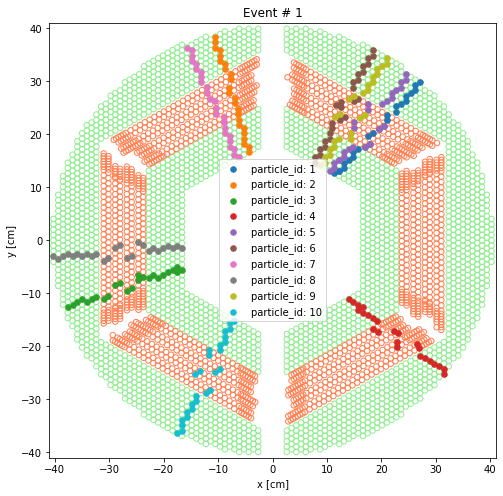

In [23]:
display_event(input_dir, 1)

## _Input Pipeline_

In [46]:
# prepare data (three version slightly different)
X, y = construct_pairs(path=input_dir, start=0, end=10)
# X,y = prepare_pairs(path=input_dir, start=0, end=10)
# X,y = prepare_pairs_list(path=input_dir, start=0, end=10)

processing  event0000000000



In [47]:
X.shape[1]

8

In [48]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [49]:
# make tf.data.Dataset object from numpy for training and testing
# trainset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(4096)
# testset= tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4096)

In [50]:
# features, labels = next(iter(train_ds))
# print(labels)
# print(features[:5])

In [51]:
# predictions = model(features)
# predictions[:5]

## _Perform EDA_

In [31]:
prefix = input_dir + str('event{!s}'.format(format(1, '010d')))
hits, truth, particles, tubes = load_event(prefix)

In [32]:
hits.head()

,hit_id,x,y,z,tube_id,skewed,layer_id,sector_id,volume_id,isochrone,depcharge,energyloss,particle_id
0,1,-6.99749,-15.150,35.0,47,0,0,2,9,0.285292,9281490.0,9.28149,10
1,2,-7.87217,-15.655,35.0,153,0,1,2,9,0.293232,4585850.0,4.58585,10
2,3,-7.87217,-16.665,35.0,266,0,2,2,9,0.187690,4601980.0,4.60198,10
3,4,-8.74686,-17.170,35.0,384,0,3,2,9,0.403716,2983620.0,2.98362,10
4,5,-8.74686,-18.180,35.0,509,0,4,2,9,0.038634,6841480.0,6.84148,10


In [33]:
hits.particle_id.unique()

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [34]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,particle_id
0,1,-7.26717,-15.0209,3.40581,-2.44911,-5.11698,1.15865,10
1,2,-7.62655,-15.7724,3.57594,-2.44676,-5.11812,1.15850,10
2,3,-8.01931,-16.5947,3.76204,-2.44454,-5.11916,1.15845,10
3,4,-8.37782,-17.3460,3.93202,-2.44204,-5.12033,1.15849,10
4,5,-8.76997,-18.1690,4.11822,-2.43937,-5.12152,1.15863,10


In [35]:
truth.particle_id.unique()

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [36]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,pdg_code,start_time
0,10,0,0,0,-2.4937,-5.09868,1.15813,-1,13,0
1,10,0,0,0,-2.4937,-5.09868,1.15813,-1,13,0
2,10,0,0,0,-2.4937,-5.09868,1.15813,-1,13,0
3,10,0,0,0,-2.4937,-5.09868,1.15813,-1,13,0
4,10,0,0,0,-2.4937,-5.09868,1.15813,-1,13,0


In [37]:
particles.particle_id.unique()

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [38]:
tubes.head()

,hit_id,tube_id,skewed,layer_id,sector_id,volume_id,isochrone,depcharge,energyloss
0,1,47,0,0,2,9,0.285292,9281490.0,9.28149
1,2,153,0,1,2,9,0.293232,4585850.0,4.58585
2,3,266,0,2,2,9,0.187690,4601980.0,4.60198
3,4,384,0,3,2,9,0.403716,2983620.0,2.98362
4,5,509,0,4,2,9,0.038634,6841480.0,6.84148


In [39]:
# first drop skewed straws. later z-axis
# hits.query('skewed==0').head()

In [40]:
plt.style.use('ggplot')

In [41]:
# truth_s = truth[['tx','ty','tz','tpx','tpy','tpz']]
# _ = truth_s.hist(figsize = (8,8))

In [42]:
# particles_s = particles[['px','py','pz']]
# _ = particles_s.hist(figsize = (8,8))

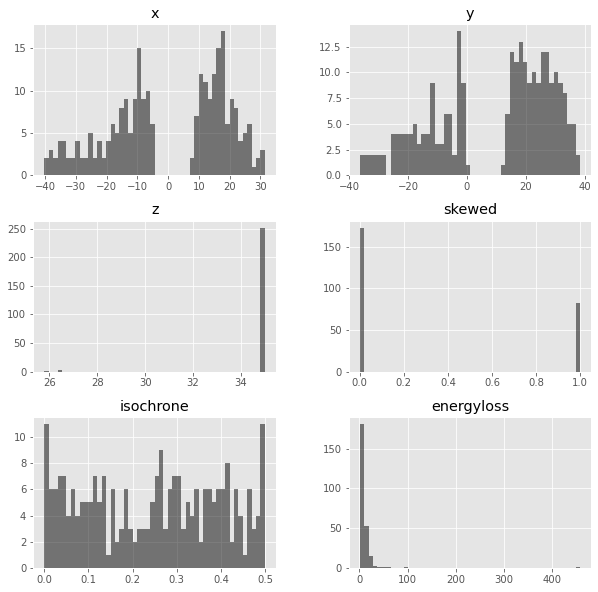

In [43]:
# Pandas: Histogram
hits_s = hits[['x', 'y', 'z', 'skewed', 'isochrone', 'energyloss']]
_ = hits_s.hist(color='b', alpha=0.5, bins=50, figsize=(10,10))

In [44]:
# Pandas: Box Plot
# color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
# hits_s.plot.box(color=color, sym='r+', figsize=(10,10))

In [45]:
# Pandas: Scatter Plot
# hits_s.plot.scatter(x='x', y='y');

In [46]:
# Pandas: Histogram Stacked
# hits_s.plot.hist(stacked=True, bins=20, figsize=(10,10))

In [47]:
# Pandas: Scatter Matrix:
#_ = pd.scatter_matrix(hits_s, figsize=(12, 12), diagonal='hist')
#_ = pd.plotting.scatter_matrix(hits_s,figsize=(12, 12), diagonal='kde')

In [48]:
# Seaborn: Pair Plot
# _ = sns.pairplot(hits_s)

In [49]:
# Seaborn: Heatmap
# plt.figure(figsize=(10,10))
# _ = sns.heatmap(hits_s.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

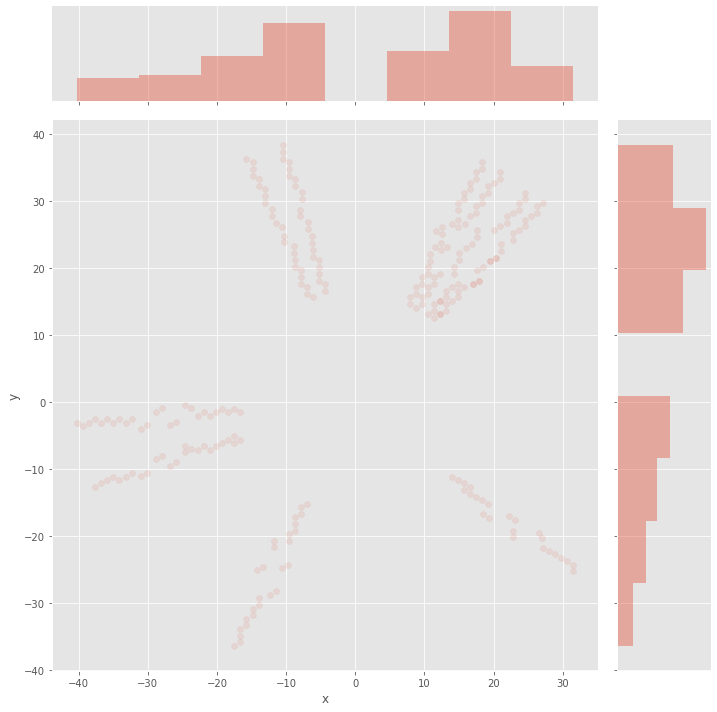

In [50]:
sns.jointplot(x="x", y="y", data=hits, alpha=0.1, height=8);

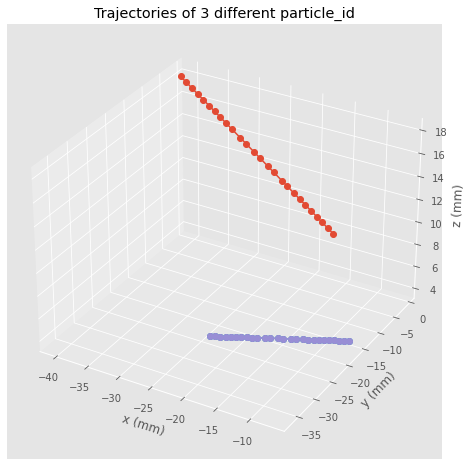

In [51]:
### Truth dataset
# For starters, let's see some trajectories from the truth dataset.

#get the information for some particles
truth_0 = truth[truth.particle_id == particles.iloc[56,0]]
truth_1 = truth[truth.particle_id == particles.iloc[10,0]]
truth_2 = truth[truth.particle_id == particles.iloc[5,0]]

#create figure instance
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

#plot each particle's path
ax.plot(
    xs=truth_0.tx,
    ys=truth_0.ty,
    zs=truth_0.tz, marker='o')

ax.plot(
    xs=truth_1.tx,
    ys=truth_1.ty,
    zs=truth_1.tz, marker='o')

ax.plot(
    xs=truth_2.tx,
    ys=truth_2.ty,
    zs=truth_2.tz, marker='o')

ax.set_title('Trajectories of 3 different particle_id')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()

In [17]:
# CreatePairs:
particle_ids = hits.particle_id.unique()
particle_ids = particle_ids[np.where(particle_ids != 0)[0]]
particle_ids.shape

(5152,)

In [18]:
particle_ids = np.sort(particle_ids)
particle_ids

array([11, 12, 13, ..., 982103, 985242, 995151], dtype=object)

In [25]:
hits[hits.particle_id == 13]

,hit_id,x,y,z,tube_id,skewed,layer_id,sector_id,isochrone,depcharge,particle_id
26,115,6.1228,-15.655,35,57,0,0,3,0.468748,4.41747e+06,13
27,116,6.1228,-16.665,35,164,0,1,3,0.11942,2.27318e+07,13
28,117,6.1228,-17.675,35,277,0,2,3,0.209066,1.19902e+07,13
29,118,6.99749,-18.18,35,397,0,3,3,0.45377,6.23718e+06,13
30,119,6.99749,-19.19,35,522,0,4,3,0.090913,1.65801e+07,13
31,120,6.99749,-20.2,35,653,0,5,3,0.231898,1.64922e+07,13
32,121,7.87217,-20.705,35,791,0,6,3,0.418135,9.16185e+06,13
33,122,7.87217,-21.715,35,934,0,7,3,0.0595036,1.29907e+07,13
42,131,11.3709,-30.805,35,2861,0,16,3,0.293707,2.26915e+07,13
43,132,11.3709,-31.815,35,3076,0,17,3,0.0266306,2.59976e+07,13


In [32]:
hits[hits.particle_id == 11].hit_id.values

array([165, 166, 167, 168], dtype=object)

In [89]:
pair = []
for particle_id in particle_ids:
    hit_ids = hits[hits.particle_id == particle_id].hit_id.values
    for i in hit_ids:
        for j in hit_ids:
            if i != j:
                pair.append([i, j])

pair = np.array(pair)

In [90]:
len(pair)

1141026

In [96]:
pair[:, 0].shape

(1141026,)

In [97]:
pair[:, 1].shape

(1141026,)

In [93]:
features[pair[:, 0]]

IndexError: index 75953 is out of bounds for axis 0 with size 75953

In [92]:
# Label = 1
Train1 = np.hstack((features[pair[:, 0]],
                    features[pair[:, 1]],
                    np.ones((len(pair), 1))))

if len(Train) == 0:
    Train = Train1
else:
    Train = np.vstack((Train, Train1))

IndexError: index 75953 is out of bounds for axis 0 with size 75953

In [ ]:
# Pair Creation
n = len(hits)
size = len(Train1)*3
p_id = hits.particle_id.values
i = np.random.randint(n, size=size)
j = np.random.randint(n, size=size)
pair = np.hstack((i.reshape(size, 1), j.reshape(size, 1)))
pair = pair[((p_id[i] == 0) | (p_id[i] != p_id[j]))]

# Label = 0
Train0 = np.hstack((features[pair[:, 0]],
                    features[pair[:, 1]],
                    np.zeros((len(pair), 1))))

Train = np.vstack((Train, Train0))

del Train0, Train1

np.random.shuffle(Train)
print(Train.shape)

In [ ]:
Train[:,:-1][0]

### EDA Hard Negative Training (Put this into a function)

In [18]:
from sklearn.preprocessing import StandardScaler
Train_hard = []

# Feature List:
features = hits[['x', 'y', 'z', 'tube_id', 'depcharge']].values

# StandardScaler:
sc = StandardScaler()
features = sc.fit_transform(features)
 
particle_ids = hits.particle_id.unique()
particle_ids = particle_ids[np.where(particle_ids != 0)[0]]

In [19]:
size=30000000
n = len(truth)
i =np.random.randint(n, size=size)
j =np.random.randint(n, size=size)
p_id = hits.particle_id.values             # truth.particle_id.values

In [20]:
pair = np.hstack((i.reshape(size,1),j.reshape(size,1)))
pair = pair[((p_id[i]==0) | (p_id[i]!=p_id[j]))]

In [21]:
Train0 = np.hstack((features[pair[:,0]], features[pair[:,1]], np.zeros((len(pair),1))))

In [22]:
pred = model.predict(Train0[:,:-1], batch_size=20000)

In [ ]:
s = np.where(pred>0.5)[0]

In [24]:
# print(event, len(Train0), len(s))

In [25]:
if len(Train_hard) == 0:
    Train_hard = Train0[s]
else:
    Train_hard = np.vstack((Train_hard,Train0[s]))

In [26]:
train = False
if train:
    Train = np.vstack((Train,Train_hard))
    np.random.shuffle(Train)
    print(Train.shape)

(12112944, 11)


In [30]:
if train:
    lr=-4
    model.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=10**(lr)), metrics=['accuracy'])
    History = model.fit(x=Train[:,:-1], y=Train[:,-1], batch_size=8000, epochs=10, verbose=1, validation_split=0.05, shuffle=True)
    model.save('sol2_stt_hard_1.h5')

Train on 11507296 samples, validate on 605648 samples
Epoch 1/10
11507296/11507296 [==============================] - 286s 25us/step - loss: 0.3780 - acc: 0.8494 - val_loss: 0.3802 - val_acc: 0.8472
Epoch 2/10
11507296/11507296 [==============================] - 284s 25us/step - loss: 0.3775 - acc: 0.8497 - val_loss: 0.3780 - val_acc: 0.8479
Epoch 3/10
11507296/11507296 [==============================] - 289s 25us/step - loss: 0.3771 - acc: 0.8499 - val_loss: 0.3783 - val_acc: 0.8482
Epoch 4/10
11507296/11507296 [==============================] - 281s 24us/step - loss: 0.3767 - acc: 0.8500 - val_loss: 0.3784 - val_acc: 0.8487
Epoch 5/10
11507296/11507296 [==============================] - 290s 25us/step - loss: 0.3763 - acc: 0.8503 - val_loss: 0.3748 - val_acc: 0.8514
Epoch 6/10
11507296/11507296 [==============================] - 294s 26us/step - loss: 0.3760 - acc: 0.8505 - val_loss: 0.3796 - val_acc: 0.8493
Epoch 7/10
11507296/11507296 [==============================] - 314s 27us/st

In [31]:
if train:
    lr=-5
    model.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=10**(lr)), metrics=['accuracy'])
    History = model.fit(x=Train[:,:-1], y=Train[:,-1], batch_size=8000, epochs=10, verbose=1, validation_split=0.05, shuffle=True)
    model.save('sol2_stt_hard_2.h5')

Train on 11507296 samples, validate on 605648 samples
Epoch 1/10
11507296/11507296 [==============================] - 265s 23us/step - loss: 0.3715 - acc: 0.8527 - val_loss: 0.3721 - val_acc: 0.8524
Epoch 2/10
11507296/11507296 [==============================] - 261s 23us/step - loss: 0.3714 - acc: 0.8528 - val_loss: 0.3719 - val_acc: 0.8525
Epoch 3/10
11507296/11507296 [==============================] - 262s 23us/step - loss: 0.3713 - acc: 0.8528 - val_loss: 0.3717 - val_acc: 0.8523
Epoch 4/10
11507296/11507296 [==============================] - 262s 23us/step - loss: 0.3712 - acc: 0.8529 - val_loss: 0.3717 - val_acc: 0.8526
Epoch 5/10
11507296/11507296 [==============================] - 262s 23us/step - loss: 0.3711 - acc: 0.8530 - val_loss: 0.3715 - val_acc: 0.8530
Epoch 6/10
11507296/11507296 [==============================] - 262s 23us/step - loss: 0.3710 - acc: 0.8530 - val_loss: 0.3716 - val_acc: 0.8527
Epoch 7/10
11507296/11507296 [==============================] - 262s 23us/st

In [32]:
if train:
    lr=-6
    model.compile(loss=['binary_crossentropy'], optimizer=Adam(lr=10**(lr)), metrics=['accuracy'])
    History = model.fit(x=Train[:,:-1], y=Train[:,-1], batch_size=8000, epochs=10, verbose=1, validation_split=0.05, shuffle=True)
    model.save('sol2_stt_hard_3.h5')

Train on 11507296 samples, validate on 605648 samples
Epoch 1/10
11507296/11507296 [==============================] - 262s 23us/step - loss: 0.3702 - acc: 0.8534 - val_loss: 0.3708 - val_acc: 0.8529
Epoch 2/10
11507296/11507296 [==============================] - 261s 23us/step - loss: 0.3701 - acc: 0.8534 - val_loss: 0.3708 - val_acc: 0.8530
Epoch 3/10
11507296/11507296 [==============================] - 262s 23us/step - loss: 0.3701 - acc: 0.8534 - val_loss: 0.3707 - val_acc: 0.8529
Epoch 4/10
11507296/11507296 [==============================] - 261s 23us/step - loss: 0.3701 - acc: 0.8534 - val_loss: 0.3708 - val_acc: 0.8529
Epoch 5/10
11507296/11507296 [==============================] - 261s 23us/step - loss: 0.3701 - acc: 0.8534 - val_loss: 0.3708 - val_acc: 0.8529
Epoch 6/10
11507296/11507296 [==============================] - 262s 23us/step - loss: 0.3701 - acc: 0.8534 - val_loss: 0.3707 - val_acc: 0.8529
Epoch 7/10
11507296/11507296 [==============================] - 262s 23us/st

## 4 - Testing Model

In [ ]:
try:
    model
except NameError:
    print('load model')
    model = load_model('sol2_stt_hard_1.h5')

In [ ]:
# Get an event:

event = 'event000001001'
hits, cells, truth, particles = get_event(event)
hit_cells = cells.groupby(['hit_id']).value.count().values
hit_value = cells.groupby(['hit_id']).value.sum().values
features = np.hstack((hits[['x','y','z']]/1000, hit_cells.reshape(len(hit_cells),1)/10,hit_value.reshape(len(hit_cells),1)))
count = hits.groupby(['volume_id','layer_id','module_id'])['hit_id'].count().values
module_id = np.zeros(len(hits), dtype='int32')

for i in range(len(count)):
    si = np.sum(count[:i])
    module_id[si:si+count[i]] = i